# **Convolution Neural Network Classifier**

Using a Convolution Neaural Network Classifier on the CIFAR10 Dataset

PyTorch and torchvision were used to load the data and build the classifer

The CIFAR-10 dataset consists of 60,000 32x32 colour images (3x32x32) in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The training set is split into 5 batches, each with 10,000 images while the testing set is one batch of 10,000 images. The classes of images are split evenly among the batches.

The CIFAR10 dataset classes include: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', and 'truck'. Each class is exclusive and there is no overlap between classes.


## Import Necessary Packages

In [ ]:
#Import the Necessary Packages
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Set up GPU Device (If Available)

In [ ]:
#Set the device as CUDA (GPU), if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


## Load and Normalize the Data

In [ ]:
#torchvision is an easy tool to load the CIFAR10 dataset
#torchvision datasets are PILImages of range [0,1]
#transform converts the data to a Tensor and normalizes the data to a range [-1,1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#Random Data Augmentation (Use if you want to augment the data randomly for each epoch)
transform_augment = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.ColorJitter(contrast = .2, hue= .2, saturation= .2, brightness = .2),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#Download training data, transform, and set up the trainloader with a specified mini-batch size (number of samples of each iteration)
#num_workers specifies how many subprocesses to use for data loading

trainloader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_augment),
                                          batch_size=5, shuffle=True, num_workers=2)

"""
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5,
                                          shuffle=True, num_workers=2)
"""
print('len(train loader)=',len(trainloader))

#Download testing data, transform, and set up the trainloader with a specified mini-batch size (number of samples of each iteration)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=5,
                                         shuffle=False, num_workers=2)
#The 10 classes of the data
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
len(train loader)= 10000
Files already downloaded and verified


## View a Few Training Examples

Looking at a few samples can help understand the data

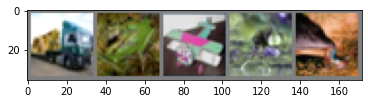

truck  frog plane  deer  bird


In [ ]:
#Defines a function to display the sample images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()     # convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  #transpose the numpy array to the correct dimensions and create an image using plt.show
    plt.show()              #Display Images


# get some random training images
# dataiter calls one iteration (One mini-batch) of samples from trainloader
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

## Define the Neural Network

Two convolution layers (including maxpooling) and three fully connected layers

In [ ]:
#Use the nn.Module to define the Convolution Neural Network
#The Convolution Neural Network includes 2 convolution layers (with maxpool) and 3 linear fully connected layers
#Relu was used as the activation function
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()     #Inherits the attributes of the nn.Module class
        
        self.conv1 = nn.Conv2d(3, 32, 5)        #3 input image channel, 32 output channels, 5x5 square convolution
        self.pool = nn.MaxPool2d(2, 2)         #2*2 Max pooling with stride of 2
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # 5*5 from image dimension
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        #Runs the input data through the network layer by layer
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Loss Function & Optimizer Function

In [ ]:
#Use the nn Module to create a Cross Entropy Loss Function
criterion = nn.CrossEntropyLoss()

#Use the torch.optim package to set up the function that updates the weights (Stochastic Gradient Descent or Adams)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=0.001)

## Train the Network

In [ ]:
training_accuracy = []
testing_accuracy = []
train_loss = []
test_loss = []

for epoch in range(15):  # loop over the dataset multiple times (epochs)

    #Initialize these values as zero at the start of each epoch
    running_loss = 0.0
    test_running_loss = 0.0
    train_total = 0.0
    train_correct = 0.0 
    for i, data in enumerate(trainloader, 0):
        # iterates over training dataset (trainloader grabs min-batches of training data ; ex.6 images)
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients (Otherwise gradients will be accumulated to exisitng gradients)
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels) #Calculate the loss
        loss.backward()   #Computes the gradients
        optimizer.step()  #Updates the weights

        #Accuracy on training set
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # print statistics
        running_loss += loss.item()   # Add the loss to the running loss
        if i % 5000 == 4999:          # print every 5000 mini-batches (epoch, number of mini-batches, and average loss)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5000))
            train_loss.append(running_loss/5000)
            running_loss = 0.0        #Reset running loss back to 0 (allows tracking of improvement over time)

    #Print training results in % accuracy        
    print('[%d] Accuracy of the network on the 50000 training images: %d %%' % (
        epoch + 1, 100 * train_correct / train_total))

    training_accuracy.append(100*train_correct/train_total) 

    #Testing Accuracy as a function of epoch number    
    #initialize correct and total values as 0
    correct = 0
    total = 0

    # Since we don't want to update weights based on the test data we use the torch.no_grad for this process
    with torch.no_grad():
        for data in testloader:
            #iterate through test data mini-batches 
            #(run data through network, use largest output number as prediction, and update total and correct values accordingly)
            #images, labels = data
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels) #Calculate the loss
            test_running_loss += loss.item()

    #Print results in % accuracy        
    print('[%d] Accuracy of the network on the 10000 test images: %d %%' % (
        epoch + 1, 100 * correct / total))
    
    testing_accuracy.append(100*correct/total)
    test_loss.append(test_running_loss/2000)
    
print('Finished Training')

[1,  5000] loss: 1.997
[1, 10000] loss: 1.692
[1] Accuracy of the network on the 50000 training images: 31 %
[1] Accuracy of the network on the 10000 test images: 42 %
[2,  5000] loss: 1.526
[2, 10000] loss: 1.411
[2] Accuracy of the network on the 50000 training images: 46 %
[2] Accuracy of the network on the 10000 test images: 52 %
[3,  5000] loss: 1.301
[3, 10000] loss: 1.246
[3] Accuracy of the network on the 50000 training images: 54 %
[3] Accuracy of the network on the 10000 test images: 57 %
[4,  5000] loss: 1.168
[4, 10000] loss: 1.131
[4] Accuracy of the network on the 50000 training images: 59 %
[4] Accuracy of the network on the 10000 test images: 61 %
[5,  5000] loss: 1.082
[5, 10000] loss: 1.062
[5] Accuracy of the network on the 50000 training images: 61 %
[5] Accuracy of the network on the 10000 test images: 62 %
[6,  5000] loss: 1.008
[6, 10000] loss: 1.006
[6] Accuracy of the network on the 50000 training images: 64 %
[6] Accuracy of the network on the 10000 test image

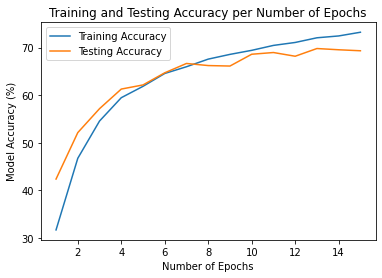

In [ ]:
#Plot the training and testing accuracy as a function of training epochs
epochs = np.linspace(1,15,15)

plt.plot(epochs, training_accuracy, label = "Training Accuracy")
plt.plot(epochs, testing_accuracy, label = "Testing Accuracy")
plt.title("Training and Testing Accuracy per Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Model Accuracy (%)")
plt.legend(loc="upper left")


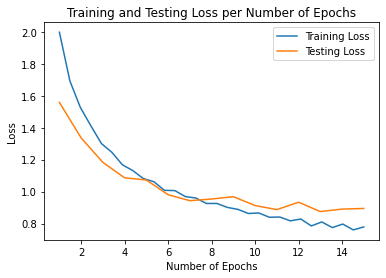

In [ ]:
#Plot of the Training and Testing Loss

epochs_alt = np.linspace(1,15,30)

plt.plot(epochs_alt, train_loss, label = "Training Loss")
plt.plot(epochs, test_loss, label = "Testing Loss")
plt.title("Training and Testing Loss per Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")


## Test Network on Small Subset of Test Set

### View Four Test Images and Their True Classes

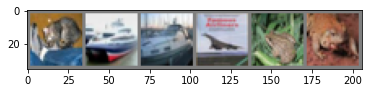

GroundTruth:    cat  ship  ship plane  frog  frog


In [ ]:
# In order to test if the Network has learned anything, it'll be tested on a small sample of test data
# dataiter calls one iteration (One mini-batch) of samples from testloader
dataiter = iter(testloader)
data = dataiter.next()
images, labels = data

# print images with the same imshow function defined earlier along with their true labels
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(6)))

### Check if Network can Predict the Four Images Correctly

In [ ]:
# run the test images displayed through the network to determine if they are classified correctly
images, labels = data[0].to(device), data[1].to(device)
outputs = net(images)

#Essentially takes the highest number at the output as the estimated classification
_, predicted = torch.max(outputs, 1)

#print results
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(6)))

Predicted:    cat  ship  ship plane  frog  frog


## Test Network on Full Test Set

Full test set of 10,000 samples

In [ ]:
#initialize correct and total values as 0
correct = 0
total = 0

# Since we don't want to update weights based on the test data we use the torch.no_grad for this process
with torch.no_grad():
    for data in testloader:
        #iterate through test data mini-batches 
        #(run data through network, use largest output number as prediction, and update total and correct values accordingly)
        #images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

#Print results in % accuracy        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 69 %


## Determine the Accuraccy per Class

Overall the model performed much better than random guess. However, there are certain classes that are likely to have poor results due to similar features. Looking at the accuracy per class we can gain insight into the problem areas of the model

In [ ]:
#Initialize the class_correct and class_total values as zero for all classes
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# Since we don't want to update weights based on the test data we use the torch.no_grad for this process
with torch.no_grad():
    for data in testloader:
        #iterate through test data mini-batches 
        #(run data through network, use largest output number as prediction)
        #images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()    #If the predicted equals the true label, c will be 1 for that data point 
        for i in range(4):
            #Update the label item class_correct and class_total values accordingly (If it was predicted corectly or not)
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

#Print out the results for each class correct/total
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 75 %
Accuracy of   car : 89 %
Accuracy of  bird : 70 %
Accuracy of   cat : 44 %
Accuracy of  deer : 64 %
Accuracy of   dog : 56 %
Accuracy of  frog : 69 %
Accuracy of horse : 66 %
Accuracy of  ship : 75 %
Accuracy of truck : 79 %
